In [1]:
# %pip install langchain
# %pip install langchain-core
# %pip install langchain-openai
# %pip install langgraph

In [2]:
# uncomment this if running locally
#!pip install python-dotenv
# from dotenv import load_dotenv

# load_dotenv()

# Or if you are in Colab, uncoment below and add your api key
import os
os.environ["OPENAI_API_KEY"] = "your-api-key"

In [1]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

In [2]:

import os
import requests
from bs4 import BeautifulSoup
# Tools: search and scraping an internet page
from langchain.tools import tool
from serpapi import GoogleSearch

serpapi_params = {
    "engine": "google",
    "api_key": os.environ["SERPAPI_KEY"]
}


@tool
def search_tool(query: str):
    """Searches the web given a user query and returns the most relevant links"""
    search = GoogleSearch({**serpapi_params, "q": query, "n": 5})
    output = search.get_dict()
    results = output["organic_results"]
    return [r["link"] for r in results]
    
@tool
def scrape_text(url: str):
    """Scrapes text from an internet page"""
    # source: copied from this script by Harrison Chase https://gist.github.com/hwchase17/69a8cdef9b01760c244324339ab64f0c
    try:
        response = requests.get(url)
        #check
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            # Extract all the text from the page
            page_text = soup.get_text(separator=" ", strip=True)
            
            return page_text
        else:
            return f"Failed to retrieve the webpage: Status code: {response.status_code}"
    
    except Exception as e:
        # In case of error print the error message
        print(e)
        return f"Failed to retrieve the webpage: {e}"

tools = [search_tool, scrape_text]
search_tool.invoke("Search the best resources to learn about how to make the best pancakes in the universe.")

['https://www.allrecipes.com/recipe/21014/good-old-fashioned-pancakes/',
 'https://www.kingarthurbaking.com/blog/2021/10/26/best-pancake-tips',
 'https://oaklandside.org/2024/11/22/green-house-bakery-pancake-recipe/',
 'https://canadianfoodfocus.org/in-your-kitchen/how-to-make-the-worlds-best-pancakes/',
 'https://cafedelites.com/best-fluffy-pancakes/',
 'https://www.thechoppingblock.com/blog/secrets-for-perfect-pancakes',
 'https://www.shemakesandbakes.com/home/perfect-pancakes',
 "https://www.dk.com/us/article/where-to-find-the-world's-best-pancakes/"]

In [3]:
search = GoogleSearch({**serpapi_params, "q": 'Pancakes', "n": 5})
output = search.get_dict()

output

{'search_metadata': {'id': '6799f84399ba83ec53f321b5',
  'status': 'Success',
  'json_endpoint': 'https://serpapi.com/searches/54750f8cadcca7e2/6799f84399ba83ec53f321b5.json',
  'created_at': '2025-01-29 09:43:31 UTC',
  'processed_at': '2025-01-29 09:43:31 UTC',
  'google_url': 'https://www.google.com/search?q=Pancakes&oq=Pancakes&sourceid=chrome&ie=UTF-8',
  'raw_html_file': 'https://serpapi.com/searches/54750f8cadcca7e2/6799f84399ba83ec53f321b5.html',
  'total_time_taken': 0.88},
 'search_parameters': {'engine': 'google',
  'q': 'Pancakes',
  'google_domain': 'google.com',
  'device': 'desktop'},
 'search_information': {'query_displayed': 'Pancakes',
  'total_results': 573000000,
  'time_taken_displayed': 0.48,
  'organic_results_state': 'Results for exact spelling'},
 'recipes_results': [{'title': 'Easy Fluffy Pancakes',
   'link': 'https://www.inspiredtaste.net/24593/essential-pancake-recipe/',
   'source': 'Inspired Taste',
   'rating': 5.0,
   'reviews': 493,
   'total_time': '3

In [4]:
tool_node = ToolNode(tools)

model = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END


# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile(checkpointer=checkpointer)

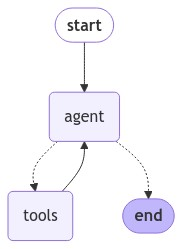

In [5]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [6]:
app.invoke({
    "messages": [
        HumanMessage(content="What are the biggest debates online regarding the best breakfast?.")
        ],
    },config={"configurable": {"thread_id": 42}})

{'messages': [HumanMessage(content='What are the biggest debates online regarding the best breakfast?.', id='772fbe29-6765-4b9c-99fb-69142e698be3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_N7c1kywcLLTgT4Ccx8E0I8Ft', 'function': {'arguments': '{"query":"biggest debates online about best breakfast"}', 'name': 'search_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 84, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-238769bc-cf89-4a56-a09b-4c2209fe9cb8-0', tool_calls=[{'name': 'search_tool', 'args': {'query': 'biggest debates online about best breakfast'}, 'id': 'call_N7c1kywcLLTgT4Ccx8E0I8Ft',